<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Introduction to CUDA Python with Numba

The **[CUDA](https://en.wikipedia.org/wiki/CUDA)** compute platform enables remarkable application acceleration by enabling developers to execute code in a massively parallel fashion on NVIDA GPUs.

**[Numba](http://numba.pydata.org/)** is a just-in-time Python function compiler that exposes a simple interface for accelerating numerically-focused Python functions. Numba is a very attractive option for Python programmers wishing to GPU accelerate their applications without needing to write C/C++ code, especially for developers already performing computationally heavy operations on NumPy arrays. Numba can be used to accelerate Python functions for the CPU, as well as for NVIDIA GPUs. **The focus of this course is the fundamental techniques needed to GPU-accelerate Python applications using Numba.**

## Course Structure

This course is divided into **three** main sections:

- _Introduction to CUDA Python with Numba_
- _Custom CUDA Kernels in Python with Numba_
- _Multidimensional Grids and Shared Memory for CUDA Python with Numba_

Each section contains a final assessment problem, the successful completion of which will enable you to earn a Certificate of Competency for the course. Each section also contains an appendix with advanced materials for those of you with interest.

### Introduction to CUDA Python with Numba

In this first section you will learn first how to use Numba to compile functions for the CPU, and will receive an introduction to the inner workings of the Numba compiler. You will then proceed to learn how to GPU accelerate element-wise NumPy array functions, along with some techniques for efficiently moving data between a CPU host and GPU device.

By the end of the first session you will be able to GPU accelerate Python code that performs element-wise operations on NumPy arrays.

### Custom CUDA Kernels in Python with Numba

In the second section you will expand your abilities to be able to launch arbitrary, not just element-wise, numerically focused functions in parallel on the GPU by writing custom CUDA kernels. In service of this goal you will learn about how NVIDIA GPUs execute code in parallel. Additionally, you will be exposed to several fundamental parallel programming techniques including how to coordinate the work of parallel threads, and how to address race conditions. You will also learn techniques for debugging code that executes on the GPU.

By the end of the second section you will be ready to GPU accelerate an incredible range of numerically focused functions on 1D data sets.

### Multidimensional Grids and Shared Memory for CUDA Python with Numba

In the third section you will begin working in parallel with 2D data, and will learn how to utilize an on-chip memory space on the GPU called shared memory.

By the end of the third section, you will be able to write GPU accelerated code in Python using Numba on 1D and 2D datasets while utilizing several of the most important optimization strategies for writing consistently fast GPU accelerated code.

## Course Prerequisites

* Competency writing Python, specifically, writing and invoking functions, working with variables, loops, and conditionals, and imports.
* Familiarity with the NumPy Python library for numerically-focused Python. If you have never used NumPy, but are familiar with Python, you will likely find the use of NumPy in this session straightforward. Comments and links are provided where some clarification might be helpful.
* A high level understanding of some computer science terms like memory allocation, value types, latency, and processing cores.
* A basic understanding of what vectors and matrices are, and also matrix multiplication.

## Objectives for this Section

By the time you complete this section you will be able to:

- Use Numba to compile Python functions for the CPU.
- Understand how Numba compiles Python functions.
- GPU accelerate NumPy ufuncs.
- GPU accelerate hand-written vectorized functions.
- Optimize data transfers between the CPU host and GPU device.

## What is Numba?

Numba is a **just-in-time**, **type-specializing**, **function compiler** for accelerating **numerically-focused** Python for either a CPU or GPU. That's a long list, so let's break down those terms:

 * **function compiler**: Numba compiles Python functions, not entire applications, and not parts of functions.  Numba does not replace your Python interpreter, but is just another Python module that can turn a function into a (usually) faster function. 
 * **type-specializing**: Numba speeds up your function by generating a specialized implementation for the specific data types you are using.  Python functions are designed to operate on generic data types, which makes them very flexible, but also very slow.  In practice, you only will call a function with a small number of argument types, so Numba will generate a fast implementation for each set of types.
 * **just-in-time**: Numba translates functions when they are first called.  This ensures the compiler knows what argument types you will be using.  This also allows Numba to be used interactively in a Jupyter notebook just as easily as a traditional application.
 * **numerically-focused**: Currently, Numba is focused on numerical data types, like `int`, `float`, and `complex`.  There is very limited string processing support, and many string use cases are not going to work well on the GPU.  To get best results with Numba, you will likely be using NumPy arrays.

## Requirements for Using Numba

Numba supports a wide range of operating systems:

 * Windows 7 and later, 32 and 64-bit
 * macOS 10.9 and later, 64-bit
 * Linux (most anything >= RHEL 5), 32-bit and 64-bit

and Python versions:

 * Python 2.7, >3.4
 * NumPy 1.10 and later

and a very wide range of hardware:

* x86, x86_64/AMD64 CPUs
* NVIDIA CUDA GPUs (Compute capability 3.0 and later, CUDA 8.0 and later)
* AMD GPUs (experimental patches)
* ARM (experimental patches)

For this course, we will be using Linux 64-bit and CUDA 9.

## Aside: CUDA C/C++ vs. Numba vs. pyCUDA

By no means is Numba the only way to program with CUDA. By far the most common way to program in CUDA is with the CUDA C/C++ language extensions. With regards to Python, [pyCUDA](https://documen.tician.de/pycuda/) is, in addition to Numba, an alternative to GPU accelerating Python code. We will remained focused on Numba throughout this course, but a quick comparison of the three options just named is worth a mention before we get started, just for a little context.

**CUDA C/C++**:
- The most common, performant, and flexible way to utilize CUDA
- Accelerates C/C++ applications

**pyCUDA**:
- Exposes the entire CUDA C/C++ API
- Is the most performant CUDA option available for Python
- Requires writing C code in your Python, and in general, a lot of code modifications

**Numba**:
- Potentially less performant than pyCUDA
- Does not (yet?) expose the entire CUDA C/C++ API
- Still enables massive acceleration, often with very little code modification
- Allows developers the convenience of writing code directly in Python
- Also optimizes Python code for the CPU

## First Steps: Compile for the CPU

If you recall Numba can be used to optimize code for either a CPU or GPU. As an introduction, and before moving onto GPU acceleration, let's write our first Numba function and compile it for the **CPU**. In doing so we will get an easy entrance into Numba syntax, and will also have an opportunity a little later on to compare the performance of CPU optimized Numba code to GPU acclerated Numba code.

The Numba compiler is typically enabled by applying a [**function decorator**](https://en.wikipedia.org/wiki/Python_syntax_and_semantics#Decorators) to a Python function. Decorators are function modifiers that transform the Python functions they decorate, using a very simple syntax. Here we will use Numba's CPU compilation decorator `@jit`:

In [1]:
from numba import jit
import math

# This is the function decorator syntax and is equivalent to `hypot = jit(hypot)`.
# The Numba compiler is just a function you can call whenever you want!
@jit
def hypot(x, y):
    # Implementation from https://en.wikipedia.org/wiki/Hypot
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)

Let's try out our hypotenuse calculation:

In [2]:
hypot(3.0, 4.0)

5.0

We will go in to more detail below about what happens when `hypot` is called, but for now know that the first time we call `hypot`, the compiler is triggered and compiles a machine code implementation of the function for float inputs. Numba also saves the original Python implementation of the function in the `.py_func` attribute, so we can call the original Python code to make sure we get the same answer:

In [3]:
hypot.py_func(3.0, 4.0)

5.0

### Benchmarking

An important part of using Numba is measuring the performance of your new code.  Let's see if we actually sped anything up.  The easiest way to do this in a Jupyter notebook, like the one this session is run in, is to use the [`%timeit` magic function](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit).  Let's first measure the speed of the original Python:

In [4]:
%timeit hypot.py_func(3.0, 4.0)

613 ns ± 0.0993 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


The `%timeit` magic runs the statement many times to get an accurate estimate of the run time.  It also returns the best time by default, which is useful to reduce the probability that random background events affect your measurement.  The best of 3 approach also ensures that the compilation time on the first call doesn't skew the results:

In [5]:
%timeit hypot(3.0, 4.0)

180 ns ± 0.0308 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


Numba did a pretty good job with this function.  It's certainly faster than the pure Python version. Of course, the `hypot` function is already present in the Python module, let's see how it compares:

In [6]:
%timeit math.hypot(3.0, 4.0)

117 ns ± 0.0556 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


Python's built-in is even faster than Numba! This is because Numba does introduce some overhead to each function call that is larger than the function call overhead of Python itself. Extremely fast functions (like the above one) will be hurt by this. (As an aside, if you call one Numba function from another one, there is very little function overhead, sometimes even zero if the compiler inlines the function into the other one. In short, always benchmark your functions for evidence of speed up.)

### Exercise: Use Numba to Compile a Function for the CPU

The following function uses [the Monte Carlo Method to determine Pi](https://academo.org/demos/estimating-pi-monte-carlo/) (source code from the [Numba homepage](http://numba.pydata.org/)). The function itself is already working so don't worry about the mathematical implementation details.

Complete the two `TODO`s in order to compile `monte_carlo_pi` with Numba before executing the following 3 cells which will:

  1. Confirm the compiled version is behaving the same as the uncompiled version.
  2. Benchmark the uncompiled version.
  3. Benchmark the compiled version.

If you get stuck, check out [the solution](../edit/solutions/monte_carlo_pi_solution.py).

In [8]:
nsamples = 1000000

In [9]:
# TODO: Import Numba's just-in-time compiler function
from numba import jit
import random

# TODO: Use the Numba compiler to compile this function
@jit
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [10]:
# We will use numpy's `testing` library to confirm compiled and uncompiled versions run the same
from numpy import testing

# This assertion will fail until you successfully complete the exercise one cell above
testing.assert_almost_equal(monte_carlo_pi(nsamples), monte_carlo_pi.py_func(nsamples), decimal=2)

In [11]:
%timeit monte_carlo_pi(nsamples)

10.6 ms ± 1.83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit monte_carlo_pi.py_func(nsamples)

320 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## How Numba Works

Now that you've gotton your hands a little dirty using the Numba compiler, let's take a look at what is actually going on under the hood. The first time we called our Numba-wrapped `hypot` function, the following process was initiated:

![Numba Flowchart](images/numba_flowchart.png "The compilation process")

We can see the result of type inference by using the `.inspect_types()` method, which prints an annotated version of the source code:

In [13]:
hypot.inspect_types()

hypot (float64, float64)
--------------------------------------------------------------------------------
# File: <ipython-input-1-1ae6c289554e>
# --- LINE 6 --- 
# label 0

@jit

# --- LINE 7 --- 

def hypot(x, y):

    # --- LINE 8 --- 

    # Implementation from https://en.wikipedia.org/wiki/Hypot

    # --- LINE 9 --- 
    #   x = arg(0, name=x)  :: float64
    #   y = arg(1, name=y)  :: float64
    #   $0.1 = global(abs: <built-in function abs>)  :: Function(<built-in function abs>)
    #   $0.3 = call $0.1(x, func=$0.1, args=[Var(x, <ipython-input-1-1ae6c289554e> (9))], kws=(), vararg=None)  :: (float64,) -> float64
    #   del x
    #   del $0.1
    #   x.1 = $0.3  :: float64
    #   del $0.3

    x = abs(x);

    # --- LINE 10 --- 
    #   $0.4 = global(abs: <built-in function abs>)  :: Function(<built-in function abs>)
    #   $0.6 = call $0.4(y, func=$0.4, args=[Var(y, <ipython-input-1-1ae6c289554e> (9))], kws=(), vararg=None)  :: (float64,) -> float64
    #   del y
    #   d

Note that Numba's type names tend to mirror [the NumPy type names](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html), so a Python `float` is a `float64` (also called "double precision" in other languages).  Taking a look at the data types can sometimes be important in GPU code because the performance of `float32` and `float64` computations can (depending on the GPU) be very different on CUDA devices. If your algorithm can obtain correct results using `float32`, then you should probably use that data type, because casting to `float64` can, depending on the GPU type, dramatically slow down the function.

## Object and nopython Modes

Numba cannot compile all Python code.  Some functions don't have a Numba-translation, and some kinds of Python types can't be efficiently compiled at all (yet).  For example, Numba does not support dictionaries (as of this writing). Here let's try to compile some Python code that Numba does not yet know how to compile:

In [14]:
@jit
def cannot_compile(x):
    return x['key']

cannot_compile(dict(key='value'))

'value'

Given what we just said, you might be surpised that the cell above executed without any problems. This is because by default, Numba will fall back to a mode, called **object mode**, which does not do type-specialization. Object mode exists to enable other Numba functionality, but in many cases, you want Numba to tell you if type inference fails. You can force **nopython mode** (the other compilation mode) by passing the `nopython` argument to the decorator:

In [15]:
@jit(nopython=True)
def cannot_compile(x):
    return x['key']

cannot_compile(dict(key='value'))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.typeinfer.ArgConstraint object at 0x7f479a703668>:
--%<----------------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/errors.py", line 599, in new_error_context
    yield
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 199, in __call__
    assert ty.is_precise()
AssertionError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 142, in propagate
    constraint(typeinfer)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 200, in __call__
    typeinfer.add_type(self.dst, ty, loc=self.loc)
  File "/home/appuser/Miniconda3/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/errors.py", line 607, in new_error_context
    six.reraise(type(newerr), newerr, tb)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/six.py", line 659, in reraise
    raise value
numba.errors.InternalError: 
[1] During: typing of argument at <ipython-input-15-d3b98ca43e8a> (3)
--%<----------------------------------------------------------------------------


File "<ipython-input-15-d3b98ca43e8a>", line 3:
def cannot_compile(x):
    return x['key']
    ^

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'dict'>

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


Now we get an exception when Numba tries to compile the function, and if you scroll down to the end of the exception output you will see an error that describes the underlying problem:
```
- argument 0: cannot determine Numba type of <class 'dict'>
```

**Using `nopython` mode is the recommended and best practice way to use `jit` as it leads to the best performance.**

Numba provides another decorator `njit` which is an alias for `jit(nopython=True)`:

In [16]:
from numba import njit

@njit
def cannot_compile(x):
    return x['key']

cannot_compile(dict(key='value'))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.typeinfer.ArgConstraint object at 0x7f479a6be7f0>:
--%<----------------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/errors.py", line 599, in new_error_context
    yield
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 199, in __call__
    assert ty.is_precise()
AssertionError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 142, in propagate
    constraint(typeinfer)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 200, in __call__
    typeinfer.add_type(self.dst, ty, loc=self.loc)
  File "/home/appuser/Miniconda3/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/errors.py", line 607, in new_error_context
    six.reraise(type(newerr), newerr, tb)
  File "/home/appuser/Miniconda3/lib/python3.6/site-packages/numba/six.py", line 659, in reraise
    raise value
numba.errors.InternalError: 
[1] During: typing of argument at <ipython-input-16-598d254e6e01> (5)
--%<----------------------------------------------------------------------------


File "<ipython-input-16-598d254e6e01>", line 5:
def cannot_compile(x):
    return x['key']
    ^

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'dict'>

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


Please refer to [the Numba documentation](https://numba.pydata.org/numba-doc/dev/reference/pysupported.html) for an exhaustive account of Numba-supported Python.

## Introduction to Numba for the GPU with NumPy Universal Functions (ufuncs)

We will begin our coverage of GPU programming in Numba with how to compile [NumPy Universal functions \(or ufuncs\)](https://docs.scipy.org/doc/numpy-1.15.1/reference/ufuncs.html) for the GPU.

The most important thing to know about GPU programming as we get started is that GPU hardware is designed for *data parallelism*. Maximum throughput is achieved when the GPU is computing the same operations on many different elements at once.

NumPy Universal functions, which perform the same operation on every element in a NumPy array, are naturally data parallel, so they are a natural fit for GPU programming.

## Review of NumPy Universal Functions (ufuncs)

Familiarity with NumPy ufuncs is a prerequisite of this course, but in case you are unfamiliar with them, or in case it has been a while, here is a very brief introduction. If, at the end of this brief introduction, you don't feel comfortable with the basic NumPy mechanisms for array creation and ufuncs, consider the ~1 hour [NumPy Quickstart Tutorial](https://docs.scipy.org/doc/numpy/user/quickstart.html).

NumPy has the concept of universal functions ("ufuncs"), which are functions that can take NumPy arrays of varying dimensions, or scalars, and operate on them element-by-element.

As an example we'll use the NumPy `add` ufunc to demonstrate the basic ufunc mechanism:

In [17]:
import numpy as np

a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])

np.add(a, b) # Returns a new NumPy array resulting from adding every element in `a` to every element in `b`

array([11, 22, 33, 44])

Ufuncs also can combine scalars with arrays:

In [18]:
np.add(a, 100) # Returns a new NumPy array resulting from adding 100 to every element in `a`

array([101, 102, 103, 104])

Arrays of different, but compatible dimensions can also be combined via a technique called [*broadcasting*](https://docs.scipy.org/doc/numpy-1.15.0/user/basics.broadcasting.html). The lower dimensional array will be replicated to match the dimensionality of the higher dimensional array. If needed, check out the docs for [`numpy.arange`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.arange.html) and [`numpy.ndarray.reshape`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.reshape.html), both will be used several times throughout this course:

In [19]:
c = np.arange(4*4).reshape((4,4))
print('c:', c)

np.add(b, c)

c: [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[10, 21, 32, 43],
       [14, 25, 36, 47],
       [18, 29, 40, 51],
       [22, 33, 44, 55]])

## Making ufuncs for the GPU

Numba has the ability to create *compiled* ufuncs, typically a not-so-straighforward process involving C code. With Numba you simply implement a scalar function to be performed on all the inputs, decorate it with `@vectorize`, and Numba will figure out the broadcast rules for you. For those of you familiar with [NumPy's `vectorize`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.vectorize.html), Numba's `vectorize` decorator will be very familiar.

In this very first example we will use the `@vectorize` decorator to compile and optimize a ufunc for the **CPU**.

In [20]:
from numba import vectorize

@vectorize
def add_ten(num):
    return num + 10 # This scalar operation will be performed on each element

In [21]:
nums = np.arange(10)
add_ten(nums) # pass the whole array into the ufunc, it performs the operation on each element

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

We are generating a ufunc that uses CUDA on the GPU with the addition of giving an **explicit type signature** and setting the `target` attribute. The type signature argument describes what types to use both for the ufuncs arguments and return value:
```python
'return_value_type(argument1_value_type, argument2_value_type, ...)'
```

Please see the Numba docs for more on [available types](https://numba.pydata.org/numba-doc/dev/reference/types.html), as well as for additional information on [writing ufuncs with more than one signature](https://numba.pydata.org/numba-doc/dev/user/vectorize.html)

Here is a simple example of a ufunc that will be compiled for a CUDA enabled GPU device. It expects two `int64` values and return also an `int64` value:

In [22]:
@vectorize(['int64(int64, int64)'], target='cuda') # Type signature and target are required for the GPU
def add_ufunc(x, y):
    return x + y

In [23]:
add_ufunc(a, b)

array([11, 22, 33, 44])

For such a simple function call, a lot of things just happened!  Numba just automatically:

 * Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.
 * Allocated GPU memory for the inputs and the output.
 * Copied the input data to the GPU.
 * Executed the CUDA kernel (GPU function) with the correct kernel dimensions given the input sizes.
 * Copied the result back from the GPU to the CPU.
 * Returned the result as a NumPy array on the host.
 
Compared to an implementation in C, the above is remarkably more concise.

You might be wondering how fast our simple example is on the GPU?  Let's see:

In [24]:
%timeit np.add(b, c)   # NumPy on CPU

1.05 µs ± 1.31 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [25]:
%timeit add_ufunc(b, c) # Numba on GPU

679 µs ± 565 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Wow, the GPU is *a lot slower* than the CPU?? For the time being this is to be expected because we have (deliberately) misused the GPU in several ways in this example. How we have misused the GPU will help clarify what kinds of problems are well-suited for GPU computing, and which are best left to be performed on the CPU:

  * **Our inputs are too small**: the GPU achieves performance through parallelism, operating on thousands of values at once.  Our test inputs have only 4 and 16 integers, respectively.  We need a much larger array to even keep the GPU busy.
  * **Our calculation is too simple**: Sending a calculation to the GPU involves quite a bit of overhead compared to calling a function on the CPU.  If our calculation does not involve enough math operations (often called "arithmetic intensity"), then the GPU will spend most of its time waiting for data to move around.
  * **We copy the data to and from the GPU**: While in some scenarios, paying the cost of copying data to and from the GPU can be worth it for a single function, often it will be preferred to to run several GPU operations in sequence. In those cases, it makes sense to send data to the GPU and keep it there until all of our processing is complete.
  * **Our data types are larger than necessary**: Our example uses `int64` when we probably don't need it.  Scalar code using data types that are 32 and 64-bit run basically the same speed on the CPU, and for integer types the difference may not be drastic, but 64-bit floating point data types may have a significant performance cost on the GPU, depending on the GPU type.  Basic arithmetic on 64-bit floats can be anywhere from 2x (Pascal-architecture Tesla) to 24x (Maxwell-architecture GeForce) slower than 32-bit floats. If you are using more modern GPUs (Volta, Turing, Ampere), then this could be far less of a concern.  NumPy defaults to 64-bit data types when creating arrays, so it is important to set the [`dtype`](https://docs.scipy.org/doc/numpy-1.14.0/reference/arrays.dtypes.html) attribute or use the [`ndarray.astype()`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.astype.html) method to pick 32-bit types when you need them.
  
  
Given the above, let's try an example that is faster on the GPU by performing an operation with much greater arithmetic intensity, on a much larger input, and using a 32-bit data type.

**Please note:** Not all NumPy code will work on the GPU, and, as in the following example, we will need to use the `math` library's `pi` and `exp` instead of NumPy's. Please see [the Numba docs](https://numba.pydata.org/numba-doc/latest/reference/numpysupported.html) for extensive coverage of NumPy support on the GPU.

In [26]:
import math # Note that for the CUDA target, we need to use the scalar functions from the math module, not NumPy

SQRT_2PI = np.float32((2*math.pi)**0.5)  # Precompute this constant as a float32.  Numba will inline it at compile time.

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [27]:
import numpy as np
# Evaluate the Gaussian a million times!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Quick test on a single element just to make sure it works
gaussian_pdf(x[0], 0.0, 1.0)

array([0.03267025], dtype=float32)

In [28]:
import scipy.stats # for definition of gaussian distribution, so we can compare CPU to GPU time
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

63.2 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit gaussian_pdf(x, mean, sigma)

4.16 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's a pretty large improvement, even including the overhead of copying all the data to and from the GPU.  Ufuncs that use special functions (`exp`, `sin`, `cos`, etc) on large data sets run especially well on the GPU.

To complete our comparison, let's define and time our `gaussian_pdf` function when optimized by Numba for the **CPU**:

In [30]:
@vectorize
def cpu_gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [31]:
%timeit cpu_gaussian_pdf(x, mean, sigma)

22.7 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's much faster than the uncompiled CPU version, but much slower than the GPU accelerated one.

## CUDA Device Functions

Ufuncs are really quite fantastic if and when you want to perform element wise operations, which is a very common task. There are any number of functions however, that do not fit this description. To compile functions for the GPU that are **not** element wise, vectorized functions, we use `numba.cuda.jit`. In the next section of this course we work extensively with `numba.cuda.jit`, but for now, let us demonstrate how to use it to decorate a helper function, to be utilized by a GPU accelerated ufunc, so that you are not required to cram all your logic into a single ufunc defintion.

Notice that `polar_to_cartesian` below does not require a type signature, and also, that it is passed two scalar values, unlike the vectorized ufuncs we have been using (and like `polar_distance` below) which expect NumPy arrays as arguments.

The argument `device=True` indicates that the decorated function can **only** be called from a function running on the GPU, and not from CPU host code:

In [32]:
from numba import cuda

@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1) # We can use device functions inside our GPU ufuncs
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

In [33]:
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

In [34]:
polar_distance(rho1, theta1, rho2, theta2)

array([2.2416651 , 1.9562645 , 0.2891031 , ..., 0.95958495, 1.3823732 ,
       1.9378368 ], dtype=float32)

Note that the CUDA compiler aggressively inlines device functions, so there is generally no overhead for function calls.  Similarly, the "tuple" returned by `polar_to_cartesian` is not actually created as a Python object, but represented temporarily as a struct, which is then optimized away by the compiler.

## Allowed Python on the GPU

Compared to Numba on the CPU (which is already limited), Numba on the GPU has more limitations.  Supported Python includes:

* `if`/`elif`/`else`
* `while` and `for` loops
* Basic math operators
* Selected functions from the `math` and `cmath` modules
* Tuples

See [the Numba manual](http://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html) for more details.

### Exercise: GPU Accelerate a Function

Let's GPU accelerate a "zero suppression" function. A common operation when working with waveforms is to force all sample values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. Let's make some sample data:

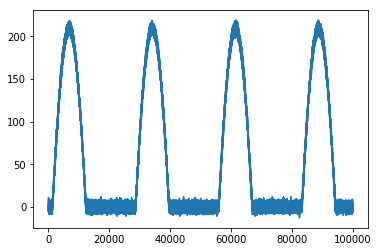

In [35]:
# This allows us to plot right here in the notebook
%matplotlib inline

# Hacking up a noisy pulse train
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

Now decorate this `zero_suppress` function to run as a vectorized ufunc on the CUDA device. Check out [the solution](../edit/solutions/zero_suppress_solution.py) if you get stuck.

In [38]:
@vectorize(['int16(int16, int16)'], target='cuda')
def zero_suppress(waveform_value, threshold):
    if waveform_value < threshold:
        result = 0
    else:
        result = waveform_value
    return result

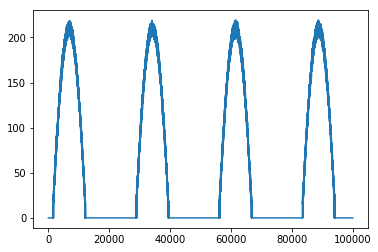

In [39]:
# This will throw an error until you successfully vectorize the `zero_suppress` function above.
# The noise on the baseline should disappear when zero_suppress is implemented
plt.plot(zero_suppress(waveform, 15))

## Managing GPU Memory

So far we have used NumPy arrays on the CPU as inputs and outputs to our GPU functions. As a convenience, Numba has been automatically transferring this data to the GPU for us so that it can be operated on by the GPU. With this implicit data transfer Numba, acting conservatively, will automatically transfer the data back to the CPU after processing. As you can imagine, this is a very time intensive operation.

The [CUDA Best Practices Guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html) indicates:

> **High Priority**: Minimize data transfer between the host and the device, even if it means running some kernels on the device that do not show performance gains when compared with running them on the host CPU.

With this in mind, we ought to consider how to prevent this automatic data transfer back to the host so that we can perform additional work on the data, only paying the price of copying it back to the host when we are truly ready.

The way to do this is to create **CUDA Device Arrays** and pass them to our GPU functions. Device arrays will not be automatically transfered back to the host after processing, and can be reused as we wish on the device before ultimately, and only if necessary, sending them, or parts of them, back to the host.

To demonstrate, let's create our example addition ufunc again:

In [40]:
@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [41]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [42]:
%timeit add_ufunc(x, y)  # Baseline performance with host arrays

1.14 ms ± 434 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The `numba.cuda` module includes a function that will copy host data to the GPU and return a CUDA device array. Note that below when we try to print the content of the device array, we only get information about the array, and not its actual contents. This is because the data is on the device, and we would need to transfer it back to the host in order to print its values, which we will show how to do later:

In [43]:
from numba import cuda

x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


Device arrays can be passed to CUDA functions just like NumPy arrays, but without the copy overhead:

In [44]:
%timeit add_ufunc(x_device, y_device)

551 µs ± 510 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Because `x_device` and `y_device` are already on the device, this benchmark is much faster.

We are, however, still allocating a device array for the output of the ufunc and copying it back to the host, even though in the cell above we are not actually assigning the array to a variable. To avoid this, we can create the output array with the [`numba.cuda.device_array()`](https://numba.pydata.org/numba-doc/dev/cuda-reference/memory.html#numba.cuda.device_array) function:

In [45]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()

And then we can use a special `out` keyword argument to the ufunc to specify the output buffer:

In [46]:
%timeit add_ufunc(x_device, y_device, out=out_device)

438 µs ± 478 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This call to `add_ufunc` does not involve any data transfers between the host and device and therefore runs the fastest. If and when we want to bring a device array back to the host memory, we can use the `copy_to_host()` method:

In [47]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


You may be thinking that we are not comparing apples to apples here since we have not been benchmarking the `to_device` calls when using the device arrays although the implicit data transfers are being counted towards the benchmarking when we use host arrays `a` and `b`, and you would be correct. Of course our `add_func` function is not particularly well suited for the GPU as discussed earlier. The above was only intended to demonstrate how the transfers can be eliminated.

Be sure to benchmark your data transfers when exploring whether or not a trip to the GPU is worth it.

Also, Numba provides additional methods for managing device memory and data transfer, check out [the docs](https://numba.pydata.org/numba-doc/dev/cuda/memory.html) for full details.

### Exercise: Optimize Memory Movement

Given these ufuncs:

In [48]:
import math

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

As it currently stands in the cell below, there is an unnecessary data roundtrip back to the host and then back again to the device in between the calls to `make_pulses` and `add_ufunc`.

Update the cell below to use device allocations so that there is only one copy to device before the call to `make_pulses` and one copy back to host after the call to `add_ufunc`. Check out [the solution](../edit/solutions/make_pulses_solution.py) if you get stuck.

In [49]:
pulses = make_pulses(t, period, 100.0)
waveform = add_ufunc(pulses, noise)

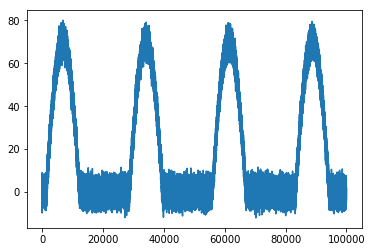

In [50]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(waveform)

## Assessment

The following exercise will require you to utilize everything you've learned so far to GPU-accelerate neural network calculations. Unlike previous exercises, there will not be any solution code available to you. Just like in this section, the other 2 notebooks in this course also have assessment problems. For those of you who successfully complete all 3, you will receive a **certificate of competency** in the course.

**Please read the directions carefully before beginning your work to ensure the best chance at successfully completing the assessment.**

### Accelerate Neural Network Calculations

You will be refactoring a simple version of some code that performs work needed to create a hidden layer in a neural network. It normalizes grayscale values, weighs them, and applies an activation function.

Your task is to move this work to the GPU using the techniques you've learned while retaining the correctness of the calculations.

### Load Imports and Initialize Values

Run this cell to import required libraries and intitialize values before beginning your work below.

In [51]:
# You should not modify this cell, it contains imports and initial values needed to do work on either
# the CPU or the GPU.

import numpy as np
from numba import cuda, vectorize

# Our hidden layer will contain 1M neurons.
# When you assess your work below, this value will be automatically set to 100M.
n = 1000000

greyscales = np.floor(np.random.uniform(0, 255, n).astype(np.float32))
weights = np.random.normal(.5, .1, n).astype(np.float32)

### GPU Accelerate

You will need to make modifications to each of the 3 cells in this section before assessing your work below. Follow the instructions in the comments.

In [63]:
# As you will recall, `numpy.exp` works on the CPU, but, cannot be used in GPU implmentations.
# This import will work for the CPU-only boilerplate code provided below, but
# you will need to modify this import before your GPU implementation will work.
from math import exp

In [64]:
# Modify these 3 function calls to run on the GPU.
@vectorize(['float32(float32)'], target='cuda')
def normalize(grayscales):
    return grayscales / 255

@vectorize(['float32(float32, float32)'], target='cuda')
def weigh(values, weights):
    return values * weights
        
@vectorize(['float32(float32)'], target='cuda')
def activate(values):
    return ( exp(values) - exp(-values) ) / ( exp(values) + exp(-values) )

In [80]:
# Modify the body of this function to optimize data transfers and therefore speed up performance.
# As a constraint, even after you move work to the GPU, make this function return a host array.
def create_hidden_layer(n, greyscales, weights, exp, normalize, weigh, activate):
    
    out_device = cuda.device_array(shape=(n,), dtype=np.float32)
    
    normalized = normalize(cuda.to_device(greyscales), out=out_device )
    weighted = weigh(cuda.to_device(normalized), cuda.to_device(weights), out=out_device)
    activated = activate(cuda.to_device(weighted), out=out_device)
    
    # The assessment mechanism will expect `activated` to be a host array, so,
    # even after you refactor this code to run on the GPU, make sure to explicitly copy
    # `activated` back to the host.
    return activated.copy_to_host()

### Check Your Work

Feel free in this section to check your work and debug as needed before running the assessment below.

In [81]:
# You probably don't need to edit this cell, unless you change the name of any of the values being passed as
# arguments to `create_hidden_layer` below.
arguments = {"n":n,
            "greyscales": greyscales,
            "weights": weights,
            "exp": exp,
            "normalize": normalize,
            "weigh": weigh,
            "activate": activate}

In [82]:
# Use this cell (and feel free to create others) to self-assess your function
a = create_hidden_layer(**arguments)
print(a)

[0.2422714  0.07958102 0.4014688  ... 0.2196576  0.01036591 0.1415901 ]


### Run the Assessment

Run the following 2 cells to assess your work.

In [83]:
from assessment import assess

In [84]:
assess(create_hidden_layer, arguments)

Setting n to 100 million.

Your function returns a host np.ndarray: True

Your function took 0.47s to run.
Your function runs fast enough (less than 1 second): True

Your function returns the correct results: True
Congratulations, you passed! See the instructions below for how to get credit for your work to count toward a certificate in the course.


## Get Credit for Your Work

After successfully passing the assessment above, revisit the webpage where you launched this interactive environment and click on the **"ASSESS TASK"** button as shown in the screenshot below. Doing so will give you credit for this part of the workshop that counts towards earning a **certificate of competency** for the entire course.

![Run the assessment](images/run_the_assessment.png)

## Summary

Now that you have completed this session you are able to:

- Use Numba to compile Python functions for the CPU
- Understand how Numba compiles functions
- GPU accelerate NumPy ufuncs
- GPU accelerate hand-written vectorized functions
- Optimize memory transfers between the CPU host and GPU device

## Download Content

To download the contents of this notebook, execute the following cell and then click the download link below. Note: If you run this notebook on a local Jupyter server, you can expect some of the file path links in the notebook to be broken as they are shaped to our own platform. You can still navigate to the files through the Jupyter file navigator.

In [ ]:
!tar -zcvf section1.tar.gz .

[Download files from this section.](files/section1.tar.gz)

## Appendix: Generalized Ufuncs

Ufuncs broadcast a scalar function over array inputs but what if you want to broadcast a lower dimensional array function over a higher dimensional array?  This is called a *generalized ufunc* ("gufunc"), and it opens up a whole new frontier for applying ufuncs.

Generalized ufuncs are a little more tricky because they need a *signature* (not to be confused with the Numba type signature) that shows the index ordering when dealing with multiple inputs.  Fully explaining "gufunc" signatures is beyond the scope of this tutorial, but you can learn more from:

* The NumPy docs on gufuncs: https://docs.scipy.org/doc/numpy/reference/c-api.generalized-ufuncs.html
* The Numba docs on gufuncs: http://numba.pydata.org/numba-doc/latest/user/vectorize.html#the-guvectorize-decorator
* The Numba docs on CUDA gufuncs: http://numba.pydata.org/numba-doc/latest/cuda/ufunc.html#generalized-cuda-ufuncs

Let's write our own normalization function.  This will take an array input and compute the L2 norm along the last dimension.  Generalized ufuncs take their output array as the last argument, rather than returning a value. If the output is a scalar, then we will still receive an array that is one dimension less than the array input. For example, computing the row sums of an array will return a 1 dimensional array for 2D array input, or 2D array for 3D array input.

In [ ]:
from numba import guvectorize
import math

@guvectorize(['(float32[:], float32[:])'], # have to include the output array in the type signature
             '(i)->()',                 # map a 1D array to a scalar output
             target='cuda')
def l2_norm(vec, out):
    acc = 0.0
    for value in vec:
        acc += value**2
    out[0] = math.sqrt(acc)

---

To test this, let's construct some points on the unit circle:

In [ ]:
angles = np.random.uniform(-np.pi, np.pi, 10)
coords = np.stack([np.cos(angles), np.sin(angles)], axis=1)
print(coords)

As expected, the L2 norm is 1.0, up to rounding errors:

In [ ]:
l2_norm(coords)

<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>